In [60]:
import numpy as np
import pandas as pd 
import seaborn as sns 

from time import time
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [61]:
def compare(data_size, lr_model, gda_model, sigma1=1, sigma2=1):

    # Training set
    cluster_1 = np.random.multivariate_normal(mean=[1,1,1], cov=[[sigma1,0,0], [0,sigma1,0],[0,0,sigma1]], size=data_size)
    cluster_1 = np.concatenate((cluster_1, np.zeros(cluster_1.shape[0])[:,np.newaxis]), axis=1)
    cluster_2 = np.random.multivariate_normal(mean=[3,3,3], cov=[[sigma2,0,0], [0,sigma2,0],[0,0,sigma2]], size=data_size)
    cluster_2 = np.concatenate((cluster_2, np.ones(cluster_1.shape[0])[:,np.newaxis]), axis=1)
    x = np.concatenate((cluster_1[:, :-1], cluster_2[:, :-1]), axis=0)
    y = np.concatenate((cluster_1[:, -1], cluster_2[:, -1]), axis=0)

    # Testing set
    cluster_1 = np.random.multivariate_normal(mean=[1,1,1], cov=[[sigma1,0,0], [0,sigma1,0],[0,0,sigma1]], size=5000)
    cluster_1 = np.concatenate((cluster_1, np.zeros(cluster_1.shape[0])[:,np.newaxis]), axis=1)
    cluster_2 = np.random.multivariate_normal(mean=[3,3,3], cov=[[sigma2,0,0], [0,sigma2,0],[0,0,sigma2]], size=5000)
    cluster_2 = np.concatenate((cluster_2, np.ones(cluster_1.shape[0])[:,np.newaxis]), axis=1)
    xt = np.concatenate((cluster_1[:, :-1], cluster_2[:, :-1]), axis=0)
    yt = np.concatenate((cluster_1[:, -1], cluster_2[:, -1]), axis=0)
    
    lr_start_time = time()
    lr_model.fit(x, y)
    time_used_in_lr = time() - lr_start_time
    pred = lr_model.predict(xt)
    acc_lr = accuracy_score(yt, pred)

    gda_start_time = time()
    gda_model.fit(x, y)
    time_used_in_gda = time() - gda_start_time
    pred = gda_model.predict(xt)
    acc_gda = accuracy_score(yt, pred)

    return time_used_in_lr, time_used_in_gda, np.mean(acc_lr), np.mean(acc_gda)

In [62]:
def a_look_at_distribution():
    from mpl_toolkits.mplot3d import Axes3D
    
    data_size = 500
    cluster_gausian_1 = np.random.multivariate_normal(mean=[1,1,1], cov=[[1,0,0], [0,1,0],[0,0,1]], size=data_size)
    cluster_gausian_2 = np.random.multivariate_normal(mean=[3,3,3], cov=[[1,0,0], [0,1,0],[0,0,1]], size=data_size)
    cluster_gausian_3 = np.random.multivariate_normal(mean=[1,1,1], cov=[[0.3,0,0], [0,0.3,0],[0,0,0.3]], size=data_size)
    cluster_gausian_4 = np.random.multivariate_normal(mean=[3,3,3], cov=[[2,0,0], [0,2,0],[0,0,2]], size=data_size)
        
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(cluster_gausian_1[:,0],cluster_gausian_1[:,1], cluster_gausian_1[:, 2], color='red')
    ax1.scatter(cluster_gausian_2[:,0],cluster_gausian_2[:,1], cluster_gausian_2[:, 2], color='blue')
    plt.title('Gausian with Same Cov')
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(cluster_gausian_3[:,0],cluster_gausian_3[:,1], cluster_gausian_3[:, 2], color='red')
    ax2.scatter(cluster_gausian_4[:,0],cluster_gausian_4[:,1], cluster_gausian_4[:, 2], color='blue')
    plt.title('Gausian with Different Cov')
    plt.show()


In [63]:
def compare_different_datasize(size_base = 2000):
    data_size_list = [x * size_base for x in range(1, 21)]
    lr_model = LogisticRegression(penalty='none',solver='lbfgs')
    gda_model = LinearDiscriminantAnalysis()
    
    time_used_lr = []
    time_used_gda = []
    acc_lr_list = []
    acc_gda_list =[]
    for data_size in data_size_list:
        lr_time_l = []
        gda_time_l = []
        lr_acc_l = []
        gda_acc_l = []
        for _ in range(10):
            lr_time, gda_time, lr_acc, gda_acc = compare(data_size, lr_model, gda_model)
            lr_time_l.append(lr_time)
            gda_time_l.append(gda_time)
            lr_acc_l.append(lr_acc)
            gda_acc_l.append(gda_acc)
        time_used_lr.append(np.mean(lr_time_l))
        time_used_gda.append(np.mean(gda_time_l))
        acc_lr_list.append(np.mean(lr_acc_l))
        acc_gda_list.append(np.mean(gda_acc_l))
    
    time_mat = pd.concat([pd.Series(time_used_gda).T, pd.Series(time_used_lr).T], axis=1)
    time_mat.columns = ['GDA', 'LR']
    plt.figure(num=1, figsize=(15, 6))
    plt.suptitle('Data Sampled from Gaussian')
    plt.subplot(121)
    fig1 = sns.regplot(data=time_mat, x=data_size_list, y='GDA', fit_reg=True, order=3)
    fig2 = sns.regplot(data=time_mat, x=data_size_list, y='LR', fit_reg=True, order=3)
    plt.legend(['GDA', 'LR'], loc='upper left')
    plt.xlabel('data size')
    plt.ylabel('time used in fit')
    plt.title('Time used in GDA.fit and LR.fit with varying data size')
    
    plt.subplot(122)
    acc_mat = pd.concat([pd.Series(acc_gda_list).T, pd.Series(acc_lr_list).T], axis=1)
    acc_mat.columns = ['GDA', 'LR']
    plt.figure(num=1, figsize=(12,7))
    fig1 = sns.regplot(data=acc_mat, x=data_size_list, y='GDA', fit_reg=True, order=3)
    fig2 = sns.regplot(data=acc_mat, x=data_size_list, y='LR', fit_reg=True, order=3)
    plt.legend(['GDA', 'LR'], loc='upper left')
    plt.xlabel('data size')
    plt.ylabel('accuracy_score')
    plt.title('Accuracy of GDA and LR with varying data size')
    plt.show()

In [76]:
def compare_different_sigma(sigma_base = 0.2):
    sigma_list = [x * sigma_base + 0.3 for x in range(1, 21)]
    lr_model = LogisticRegression(penalty='none',solver='lbfgs')
    gda_model = LinearDiscriminantAnalysis()
    
    time_used_lr = []
    time_used_gda = []
    acc_lr_list = []
    acc_gda_list =[]
    for sigma in sigma_list:
        lr_time_l = []
        gda_time_l = []
        lr_acc_l = []
        gda_acc_l = []
        for _ in range(10):
            lr_time, gda_time, lr_acc, gda_acc = compare(2000, lr_model, gda_model, sigma1=0.3, sigma2=sigma)
            lr_time_l.append(lr_time)
            gda_time_l.append(gda_time)
            lr_acc_l.append(lr_acc)
            gda_acc_l.append(gda_acc)
        time_used_lr.append(np.mean(lr_time_l))
        time_used_gda.append(np.mean(gda_time_l))
        acc_lr_list.append(np.mean(lr_acc_l))
        acc_gda_list.append(np.mean(gda_acc_l))
    
    plt.figure(figsize=(8,7))
    acc_mat = pd.concat([pd.Series(acc_gda_list).T, pd.Series(acc_lr_list).T], axis=1)
    acc_mat.columns = ['GDA', 'LR']
    fig1 = sns.regplot(data=acc_mat, x=sigma_list, y='GDA', fit_reg=True, order=3)
    fig2 = sns.regplot(data=acc_mat, x=sigma_list, y='LR', fit_reg=True, order=3)
    plt.legend(['GDA', 'LR'], loc='upper left')
    plt.xlabel('Sigma_1')
    plt.ylabel('accuracy_score')
    plt.title('Accuracy of GDA and LR with varying Sigma_1 and fixed Sigma_0 ')
    plt.show()

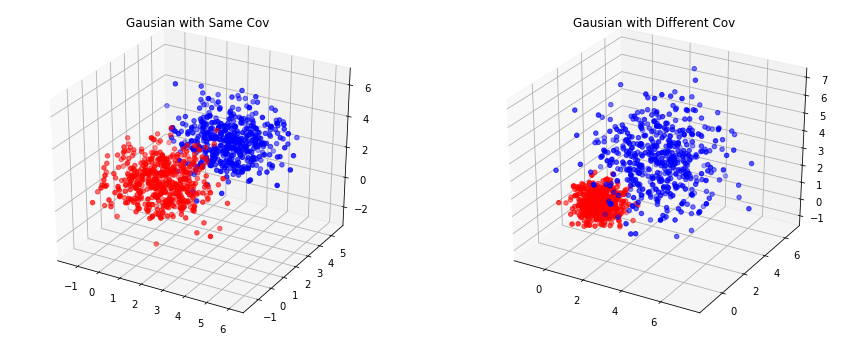

In [65]:
# 查看两种噪声的形态差异
a_look_at_distribution()

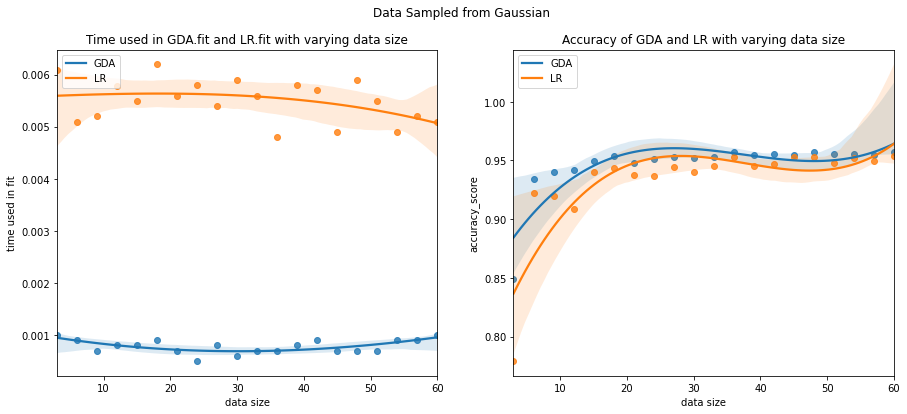

In [66]:
# 比较GDA和LR两种模型 对服从高斯分布的数据的拟合能力、拟合速度
# 现象： 左侧中蓝色表示的GDA模型拥有更快的拟合速度， 右侧显示在小样本下GDA有更好的准确率
compare_different_datasize(size_base=3)

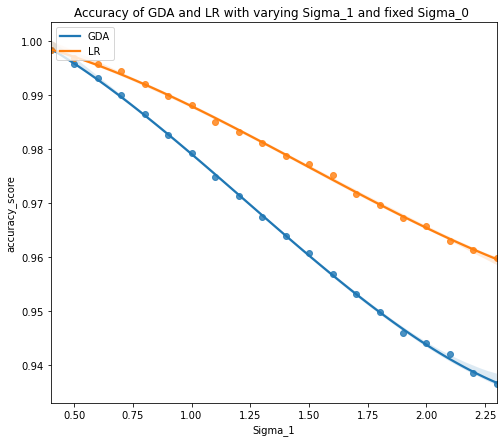

In [77]:
# 检验当LDA假设偏移时的性能损失，固定类别0为协方差0.3I的高斯分布，取类别1协方差为0.3I至2I
# 结论：当两类分布接近时GDA与LR性能接近，随着分布差异变大，GDA性能损失大于LR
compare_different_sigma(sigma_base = 0.1)